# Video style transfer

## Import libraries

In [2]:
import matplotlib.pyplot as plt 
import time

from tqdm import trange

import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models
import HRNet
import utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('------------------------------------------------------------------')
print(torch.__version__,device)
print('------------------------------------------------------------------')

/content/drive/Shareddrives/CSCI 590 - Directed Research/Rong/video transfer
------------------------------------------------------------------
1.12.1+cu113 cuda
------------------------------------------------------------------


## Load VGG and HRNet models

In [ ]:
torch.manual_seed(0)

VGG = models.vgg19(pretrained=True).features
VGG.to(device)

style_net = HRNet.HRNet()

style_net.to(device)

for parameter in VGG.parameters():
    parameter.requires_grad_(False)


## Set hyperparameters

In [4]:
#default VGG abstracting weights
style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

optimizer = optim.Adam(style_net.parameters(), lr=1e-3)

#fine-tune these two hyperparameters carefully! Restart and run all after changing them.
content_weight = 10
style_weight = 1


## Load content and style images; Convert them into tensors running on the GPU 

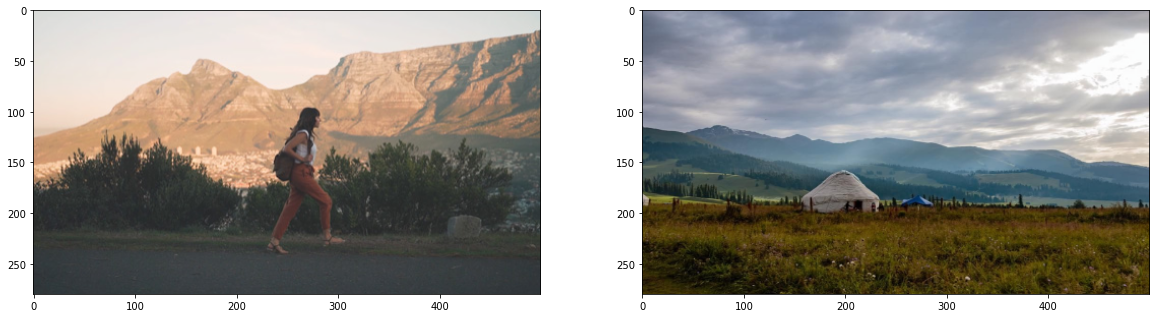

In [5]:

input = utils.load_image("./frames/1.jpg")
content_image = transforms.functional.resize(input, (280,500))
content_image = content_image.to(device)
style_image = utils.load_image("./styles/in47.png")
style_image = transforms.functional.resize(style_image, (280,500))
style_image = style_image.to(device)

content_features = utils.get_features(content_image, VGG)
style_features   = utils.get_features(style_image, VGG)

style_gram_matrixs = {layer: utils.get_grim_matrix(style_features[layer]) for layer in style_features}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(style_image))
plt.show()

## Train the HRNet model

After 0 criterions:
Total loss:  46.315582275390625
Content loss:  4.631558418273926
Style loss:  203.3189239501953


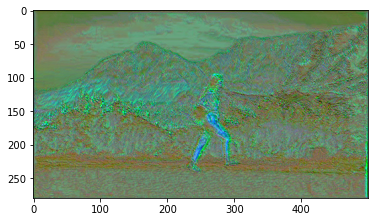

After 100 criterions:
Total loss:  5.802084922790527
Content loss:  0.5802084803581238
Style loss:  20.726770401000977


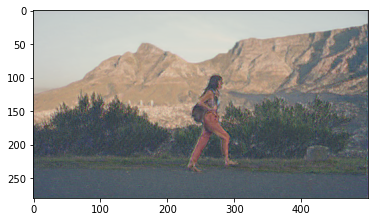

After 200 criterions:
Total loss:  3.070462942123413
Content loss:  0.3070462942123413
Style loss:  18.263341903686523


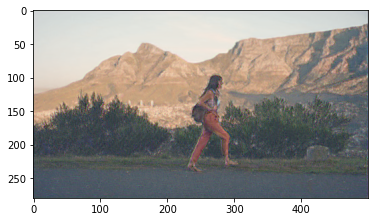

After 300 criterions:
Total loss:  2.337322950363159
Content loss:  0.23373229801654816
Style loss:  17.83706283569336


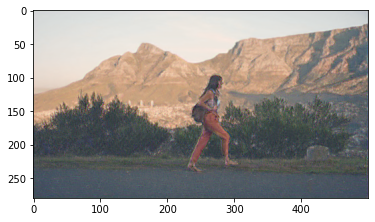

After 400 criterions:
Total loss:  1.8157739639282227
Content loss:  0.1815773993730545
Style loss:  17.365234375


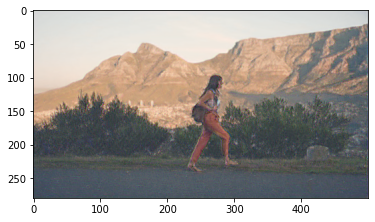

After 500 criterions:
Total loss:  18.630340576171875
Content loss:  0.15718001127243042
Style loss:  17.05854034423828


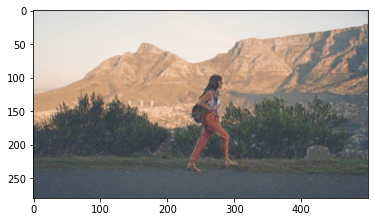

After 600 criterions:
Total loss:  11.115923881530762
Content loss:  0.3807695209980011
Style loss:  7.308228492736816


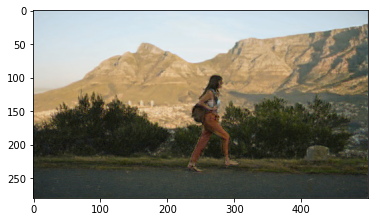

After 700 criterions:
Total loss:  9.956292152404785
Content loss:  0.330881267786026
Style loss:  6.64747953414917


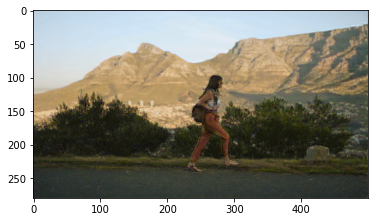

After 800 criterions:
Total loss:  9.411754608154297
Content loss:  0.31559011340141296
Style loss:  6.255853652954102


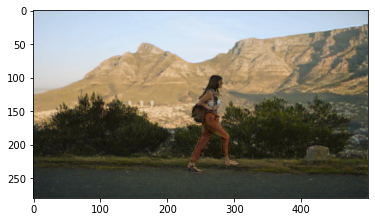

After 900 criterions:
Total loss:  9.34980583190918
Content loss:  0.31628113985061646
Style loss:  6.186995029449463


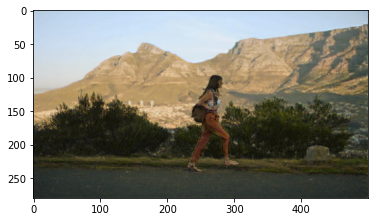

totally cost 39.7085497379303


In [6]:
time_start=time.time()
for epoch in range(0, 1000):
    
    if epoch < 500:
        style_weight = 0
    else:
        style_weight = 1
    target = style_net(content_image).to(device)
    target.requires_grad_(True)
    

    target_features = utils.get_features(target, VGG)  # extract output image's all feature maps
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0

    # compute each layer's style loss and add them
    for layer in style_weights:
        
        target_feature = target_features[layer]  # output image's feature map after layer
        target_gram_matrix = utils.get_grim_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss = style_loss + layer_style_loss / (c * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("After %d criterions:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('Style loss: ', style_loss.item())
        plt.imshow(utils.im_convert(target))
        plt.show()

    output_image = target
time_end=time.time()
print('totally cost', time_end - time_start)

## Display the comparision

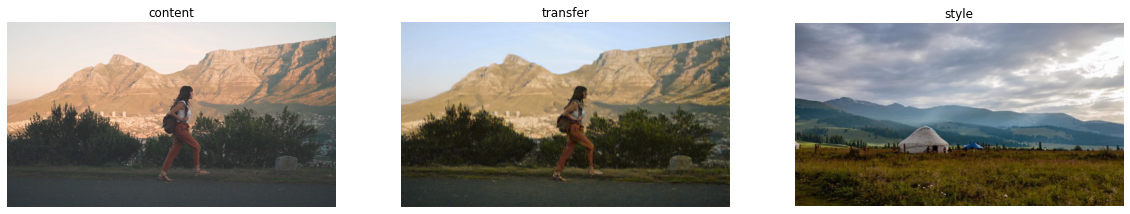

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
output_image = transforms.functional.resize(output_image, (input.shape[2],input.shape[3]))

ax1.imshow(utils.im_convert(input))
ax1.set_title('content')
ax2.imshow(utils.im_convert(output_image))
ax2.set_title('transfer')
ax3.imshow(utils.im_convert(style_image))
ax3.set_title('style')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

## Apply the model to all frames (If satisfied)

In [ ]:
for i in trange(1,251):
  input = utils.load_image("./frames/"+str(i)+".jpg")
  content_image = transforms.functional.resize(input, (280,500))
  content_image = content_image.to(device)
  target = style_net(content_image).to(device)
  plt.figure(figsize=(12.8,7.2))
  plt.axis('off')
  plt.imsave('results/'+str(i)+'.jpg',utils.im_convert(target))
